In [4]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import torch
# from corner import corner
from tqdm import trange
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [5]:
def gaussian(x, centers, sigmas, amplitudes):
    """Add multiple Gaussian features.

    Args:
        x (np.ndarray): Input x-axis (e.g., wavelengths).
        centers (list): List of Gaussian centers.
        sigmas (list): List of Gaussian standard deviations.
        amplitudes (list): List of Gaussian amplitudes.

    Returns:
        np.ndarray: Sum of all Gaussian features evaluated at x.
    """
    y = np.ones_like(x)
    for c, s, a in zip(centers, sigmas, amplitudes):
        y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
    return y

def simulator(obs, pars, thread=0):
    ndims=pars.shape[1]

    c=pars[:,0:ndims//3]
    s=pars[:,ndims//3:2*ndims//3]
    a=pars[:,2*ndims//3:3*ndims//3]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Create synthetic observation to test

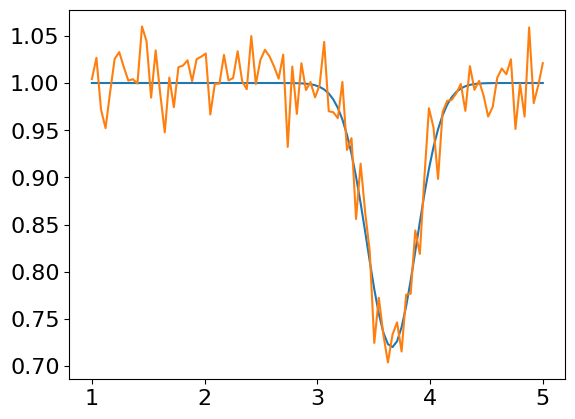

In [ ]:
wvl = np.linspace(1,5,100)
f = gaussian(wvl, [3.66], [0.22], [0.28])
noise=0.03*np.random.standard_normal(len(wvl))
plt.plot(wvl, f)
plt.plot(wvl, f+noise)

synthobs = helpers.create_obs_file(wvl, f+noise, 0.03*np.ones_like(f))

np.savetxt("../src/floppity/data/obs_3.66_0.22_0.28.txt", synthobs)

### Run nested sampling to have as baseline

In [37]:
import dynesty

def log_likelihood(x):
    OBS = synthobs
    simulated = gaussian(OBS[:,0],[x[0]], [x[1]], [x[2]])
    residual = OBS[:,1] - simulated
    log_L = -0.5 * np.sum((residual**2 / OBS[:,2]**2) + np.log(2 * np.pi * OBS[:,2]**2))
    return log_L


def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior"""
    x=np.array(u)
    x[0]=1+4*u[0]
    x[1]=0.1+0.6*u[1]
    x[2]=u[2]

    return x

In [55]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, 3, nlive=5000)
sampler.run_nested(dlogz=0.01)

99325it [01:17, 1283.22it/s, +5000 | bound: 26 | nc: 1 | ncall: 370175 | eff(%): 28.568 | loglstar:   -inf < 290.283 <    inf | logz: 275.030 +/-  0.052 | dlogz:  0.000 >  0.010] 


In [ ]:
sresults = sampler.results

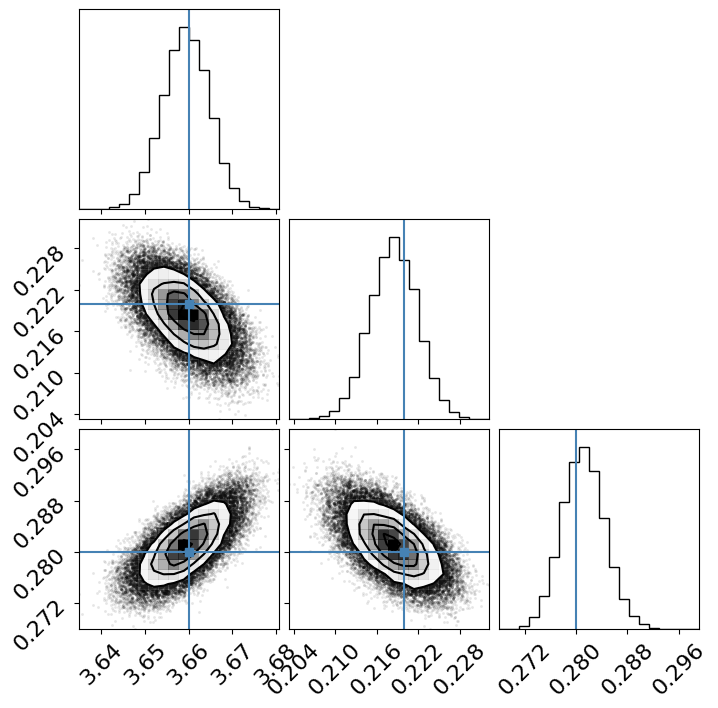

In [57]:
from corner import corner
fig=corner(sresults.samples_equal(),
truths=[3.66, 0.22, 0.28])

### Setup retrieval

In [198]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(["../src/floppity/data/obs_3.66_0.22_0.28.txt"])

### Add parameters
R.add_parameter('center', 1, 5)
R.add_parameter('sigma', 0.1, 0.7)
R.add_parameter('amplitude', 0, 1)

In [199]:
# training_kwargs= dict(
#     stop_after_epochs = 20,
#     num_atoms = 30,
#     learning_rate=5e-4
# )

# flow_kwargs=dict(
#     flow='nsf',
#     bins=6,
#     transforms=12,
#     blocks=2,
#     hidden=32,
#     dropout=0.35
# )

### Run retrieval

In [200]:
R.run(
    # flow_kwargs=flow_kwargs, 
    # resume=False, 
    # n_threads=4, 
    # training_kwargs=training_kwargs, 
    n_rounds=1, 
    n_samples=1000
    )

Starting training...
Round 1
 Training neural network. Epochs trained: 12

KeyboardInterrupt: 

### Save retrieval object

In [85]:
R.save('/Users/floppityflappity/Work/R_10_8_15_1k_2.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [4]:
R=Retrieval.load('r.pkl')

### Resume training

In [192]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=1, training_kwargs=training_kwargs, n_rounds=1, n_samples=1000)

Resuming training...
Round 1


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 94 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 94
        Best validation performance: -15.8227
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

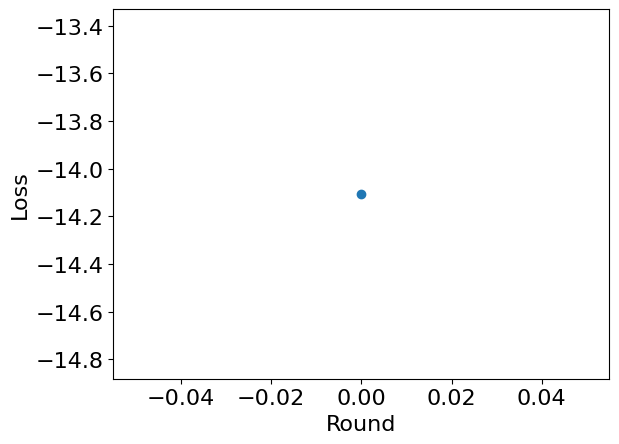

In [196]:
plt.plot(R.inference._summary['validation_loss'][-1], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

Drawing 104325 posterior samples:   0%|          | 0/104325 [00:00<?, ?it/s]

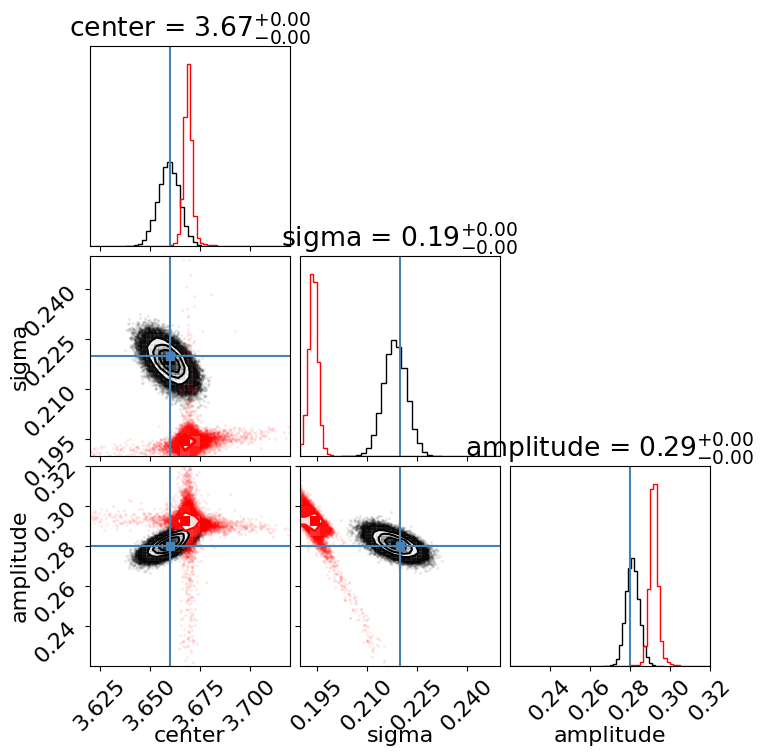

In [193]:
#plot nested sampling posterior
samples = sresults.samples_equal()
narrow=[(3.62,3.72),(0.19,0.25),(0.22,0.32)]
broad=[(1.,5),(0.1,0.7),(0.,1)]
CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    color='k'
)
ns = corner(sresults.samples_equal())

CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    fig=ns,
    color='red'
)
fig=R.plot_corner(-1,n_samples=len(samples),**CORNER_KWARGS)

## Posterior diagnostics

### Posterior predictive check

100%|██████████| 200/200 [00:00<00:00, 1885.41it/s]


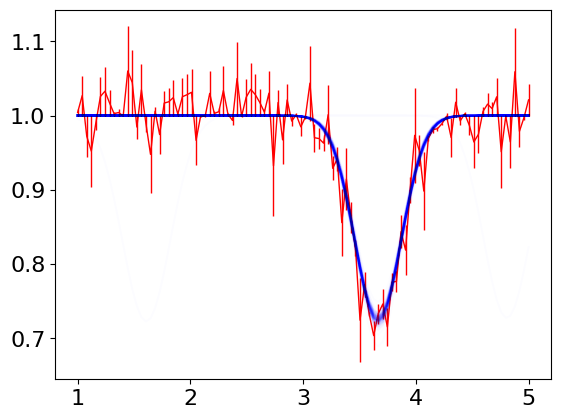

In [179]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=abs(R.obs[key][:,2]), c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

In [24]:
from floppity import plot_utils
plot_utils.plot_moment_evolution(R.proposals[:], 5, compute_moments, R=R, num_repeats=3, sample_size=1000)

NameError: name 'compute_moments' is not defined